In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pprint
import os

# custom functions
from timeseries import time_series_split
from lstm import univar_split_sequence, multivar_split_sequence, tensor_format, evaluation, plot_lstm

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set figure aesthetics
sns.set_style("darkgrid")

# Sunspot Data Problem from DARPA

*Author: Koki Sasagawa*  
*Date: 4/23/2019*

Sunspots are a temporary phenomena on the sun's surface where cooler spots appear as dark spots. The data is by structure a time series, where the yearly mean total sunspot number is given for each year. 

Two datasets are given: 
1. Yearly Mean Total Sunspots univariate (1700 - 2018) - arithmetic mean of the daily total sunspot number over all days of each year
2. Yearly Mean Total Sunspots multivariate (1818 - 2018) - arithmetic mean of daily total sunspot number over all days of each year

In [3]:
raw_data = './data/raw/'

files = os.listdir(raw_data)
for idx, fname in enumerate(files):
    print(idx, fname)

0 sunspots_yr_mean_train.csv
1 sunspots_yr_mean_test.csv
2 sunspots_yearly_multivariate-test.csv
3 sunspots_yearly_multivariate-train.csv


## Univariate LSTM

|trial | window size | Model parameters                           | RMSE  | 
|:-----|:------------|:-------------------------------------------|:------|
| 1    | 10          | Layers (10, 1), epochs=100, batch_size=248 | 70.15 |
| 2    | 10          | bidirectional ...                          | 41.86 |
| 3    | 10          | epoch to 50 ...                            | 66.7  |
| 4    | 8           | ...                                        | 56.26 |
| 5    | 15          | ...                                        | 61.42 |
| 6    | 12          | ...                                        | 63.75 | 
| 7    | 10          | batch_size=277 ...                         | 50.38 |
| 8    | 10          | batch_size=100 ...                         | 31.86 |
| 9    | 10          | batch_size=277, epoch=500 ...              | 23.06 |
| 10   | 10          | epoch=300 ...                              | 32.6  | 
| 11   | 10          | learning algorithm='Adadelta' ...          | 28.6  |
| 12   | 10          | epoch=200 ...                              | 39.39 | 
| 13   | 10          | bidirectional Layers (15, 1) ...           | 21.9  | 
| 14   | 10          | epoch=150                                  | 22.26 |  

In [115]:
# load data
uni_var_train = pd.read_csv(raw_data + 'sunspots_yr_mean_train.csv')
print("Dimensions: {}".format(uni_var_train.shape))
uni_var_train.head()

Dimensions: (287, 2)


,year,sunspots
0,1700,8.3
1,1701,18.3
2,1702,26.7
3,1703,38.3
4,1704,60.0


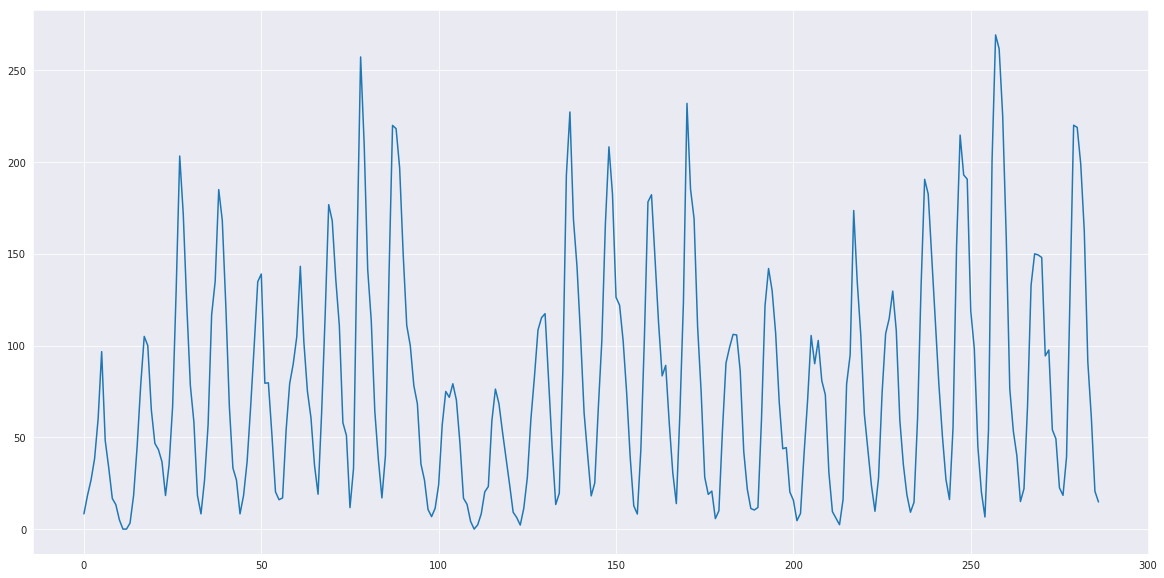

In [116]:
# visualize
plt.figure(figsize=(20,10))
plt.plot(uni_var_train['sunspots'])
plt.show()

In [119]:
# Format data into input for LSTM model
train_list = uni_var_train['sunspots'].tolist()
X_train, y_train = univar_split_sequence(train_list, 10)
X_train = tensor_format(X_train, 1)
print(X_train.shape)

# Display first data point
print(X_train[0], y_train[0])

(277, 10, 1)
[[ 8.3]
 [18.3]
 [26.7]
 [38.3]
 [60. ]
 [96.7]
 [48.3]
 [33.3]
 [16.7]
 [13.3]] 5.0


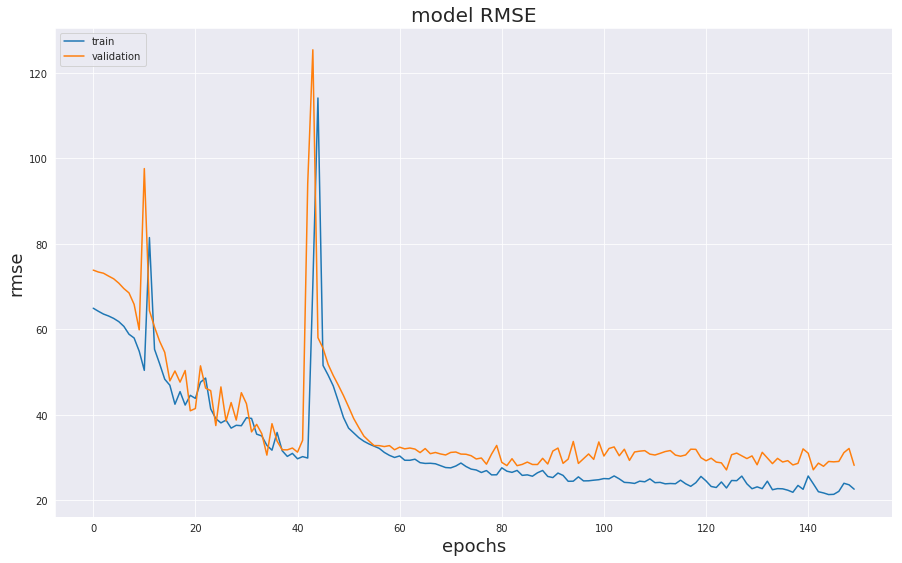

In [130]:
# Define the LSTM model
steps = 10
features = 1 

model = Sequential()
model.add(Bidirectional(LSTM(units=15, activation='relu', input_shape=(steps, features))))
model.add(Dense(1))
model.compile(optimizer='Adadelta', loss='mse')
history = model.fit(X_train, y_train, epochs=150, verbose=0, batch_size=277,  validation_split=0.1)
plot_lstm(history, 'trial_14')

In [131]:
# Plot predictions for validation set
train, val = time_series_split(uni_var_train, split=0.9)
train_list = train['sunspots'].tolist()
val_list = val['sunspots'].tolist()

# For the first prediction of the validation set, start from using the last 10 entries of the training set. 
val_list = train_list[-10:] + val_list
X_val, y_val = univar_split_sequence(val_list, 10)
X_val = tensor_format(X_val, 1)
print(X_val.shape)

Size of original data: 287
Size of training data: 258
Size of test data: 29
(29, 10, 1)


In [132]:
predictions = model.predict(X_val)

MSE: 780.0703
RMSE: 27.9297


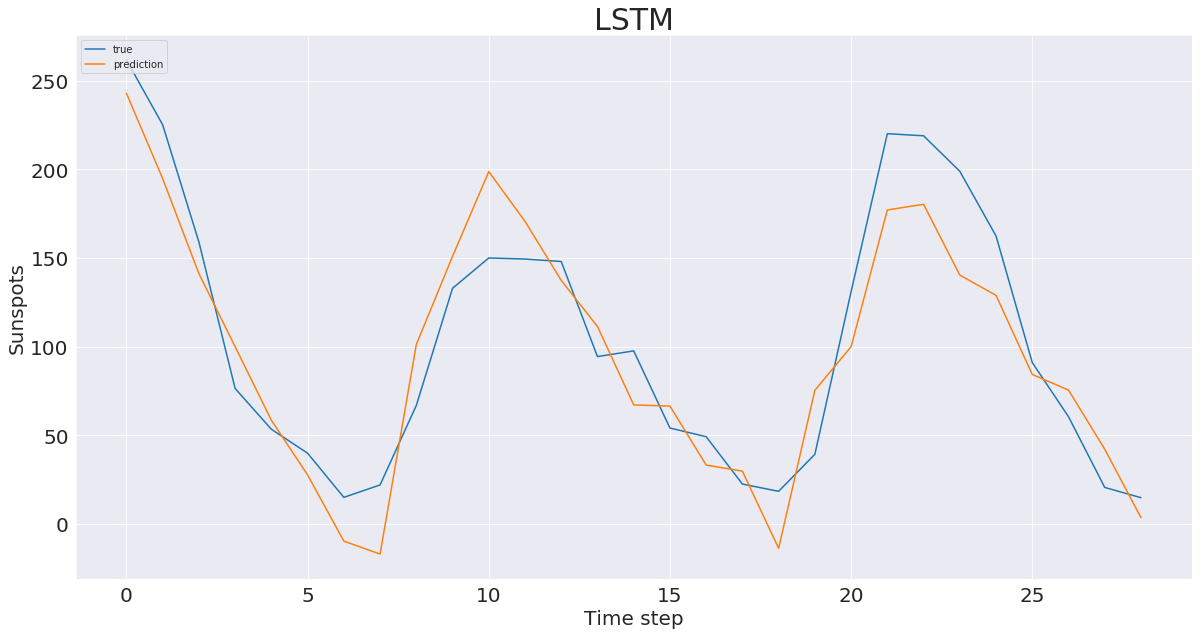

In [133]:
evaluation(y_val, predictions)

## Final univariate LSTM predictions

In [134]:
uni_var_test = pd.read_csv(raw_data + 'sunspots_yr_mean_test.csv')
print("Dimensions: {}".format(uni_var_test.shape))
uni_var_test.head()

Dimensions: (32, 2)


,year,sunspots
0,1987,NaN
1,1988,NaN
2,1989,NaN
3,1990,NaN
4,1991,NaN


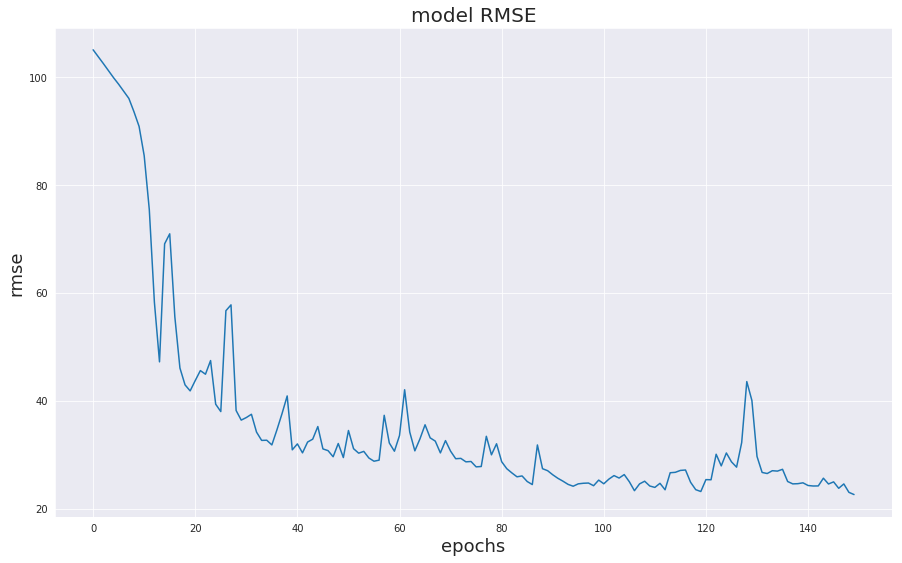

In [137]:
# Fully trained model
steps = 10
features = 1 

model = Sequential()
model.add(Bidirectional(LSTM(units=15, activation='relu', input_shape=(steps, features))))
model.add(Dense(1))
model.compile(optimizer='adadelta', loss='mse')
history = model.fit(X_train, y_train, epochs=150, verbose=0, batch_size=277)
plot_lstm(history, 'train_history', val=False)

In [138]:
predictions = []
# Last 10 entires of training set to make future predictions 
test_input  = val_list[-10:]

# 32 predictions into the future
for i in range(uni_var_test.shape[0]):
    X = test_input + predictions
    # Top 10 newest data each time 
    X = np.array(X[-10:])
    X = np.expand_dims(X, axis=0) # add samples = 1 to dimension
    X = tensor_format(X, 1) # add features = 1 to dimension
    predict = model.predict(X)
    predictions.append(predict)

In [139]:
values = [x[0] for x in predictions]

In [140]:
# Compare the LSTM results againt the ARIMA predictions
arima_predictions = pd.read_csv('./arima_predictions.csv')
arima = arima_predictions['sunspots'].tolist()

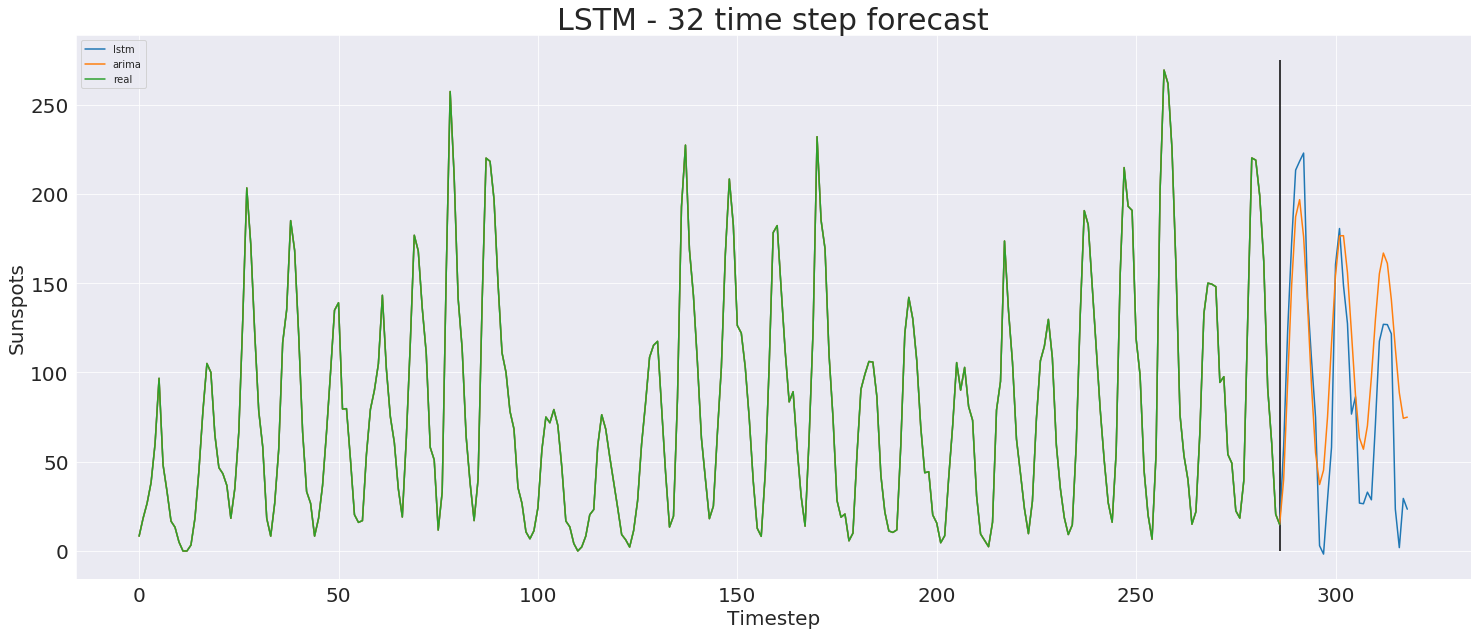

In [141]:
plt.figure(figsize=(25, 10))
plt.plot(uni_var_train['sunspots'].tolist() + values)
plt.plot(uni_var_train['sunspots'].tolist() + arima)
plt.plot(uni_var_train['sunspots'].tolist())
plt.legend(['lstm', 'arima', 'real'], loc='upper left')
plt.title("LSTM - 32 time step forecast", fontdict={'fontsize': 30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Timestep', fontsize=20)
plt.ylabel('Sunspots', fontsize=20)
plt.vlines(286, ymin=0, ymax=275)
plt.show()

In [142]:
uni_var_test['sunspots'] = [x[0] for x in values]
uni_var_test.head()

,year,sunspots
0,1987,58.628220
1,1988,123.263268
2,1989,172.642334
3,1990,213.276566
4,1991,218.246902


In [143]:
# uni_var_test.to_csv('./LSTM_univariate_predictions3.csv', index=False)

## Multivariate LSTM

|trial | window size | Model parameters                                                                     | RMSE  | 
|:-----|:------------|:------------------------------------------------------------------------------------:|:------|
| 1    | 10          | Layers (10, 1), epochs=100, batch_size=170                                           | 124.29|
| 2    | 10          | bidirectional Layers (10, 1), ...                                                    | 36.36 |
| 3    | 10          | bidirectional Layers (20, 1), ...                                                    | 38.04 |
| 4    | 10          | bidirectional Layers (10, 10, 1) ...                                                 | 125.63|
| 5    | 10          | bidirectional Layers (10, 1), epochs=300, ...                                        | 42.69 |
| 6    | 10          | bidirectional Layers (30, 1), ...                                                    | 48.72 |
| 7    | 10          | learning algorithm='adadelta', ...                                                   | 26.82 |
| 8    | 10          | dropout layer 0.2 ...                                                                | 27.72 |
| 9    | 10          | epochs=150 ...                                                                       | 23.10 |

In [44]:
# load data
multi_var_train = pd.read_csv(raw_data + 'sunspots_yearly_multivariate-train.csv')
print("Dimensions: {}".format(multi_var_train.shape))
multi_var_train.head()

Dimensions: (180, 4)


,year,sd,observations,sunspots
0,1818,9.2,213,52.9
1,1819,7.9,249,38.5
2,1820,6.4,224,24.2
3,1821,4.2,304,9.2
4,1822,3.7,353,6.3


Visualize the different features

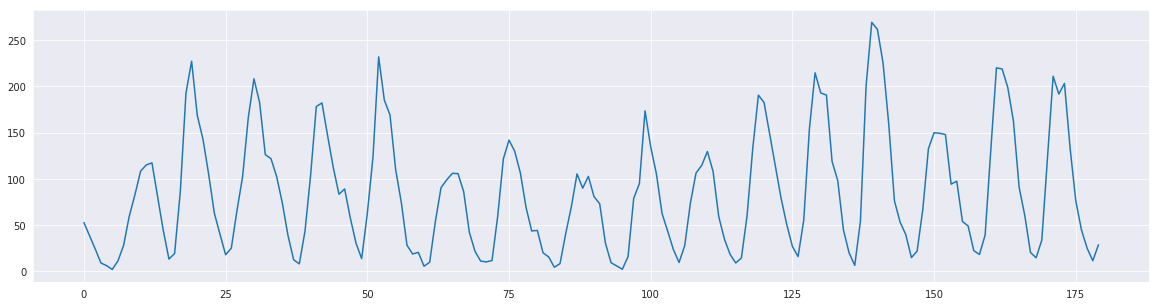

In [46]:
plt.figure(figsize=(20,5))
plt.plot(multi_var_train['sunspots'])
plt.show()

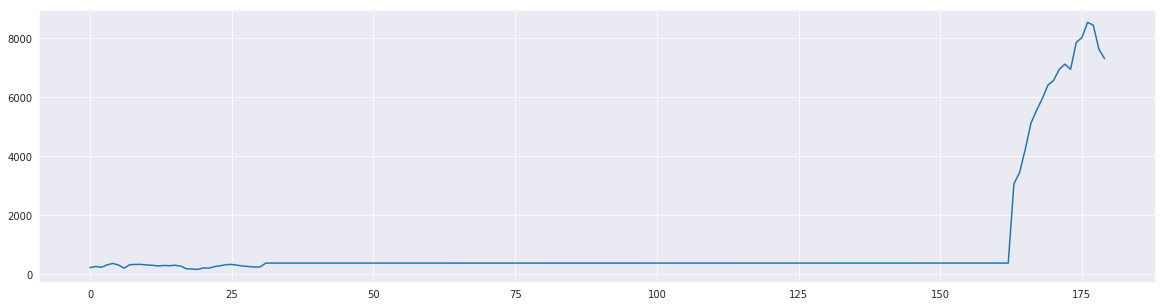

In [47]:
plt.figure(figsize=(20,5))
plt.plot(multi_var_train['observations'])
plt.show()

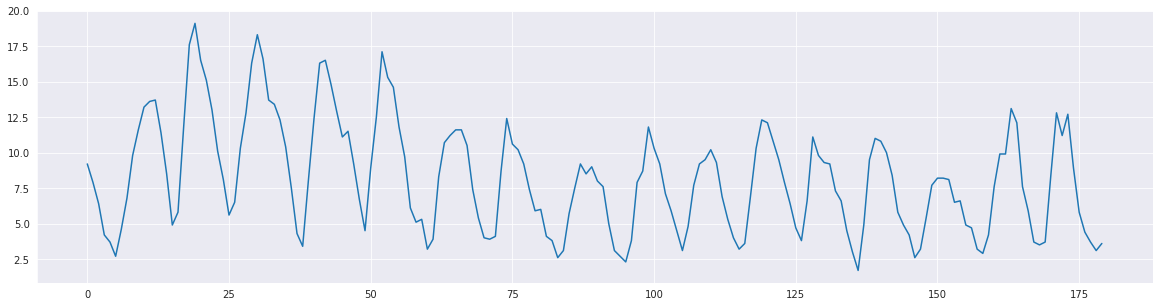

In [48]:
plt.figure(figsize=(20, 5))
plt.plot(multi_var_train['sd'])
plt.show()

Since observations seems flat and uninformative for the majority, we will remove this feature

In [49]:
feature1 = np.array(multi_var_train['sd'].tolist())
# feature2 = np.array(multi_var_train['observations'].tolist())
feature3 = np.array(multi_var_train['sunspots'].tolist())

feature1 = feature1.reshape((len(feature1), 1))
# feature2 = feature2.reshape((len(feature2), 1))
feature3 = feature3.reshape((len(feature3), 1))

# horizontally stack columns
dataset = np.hstack((feature1, feature3, feature3))

In [50]:
X_train, y_train = multivar_split_sequence(dataset, 10)
print(X_train.shape)

(170, 10, 2)


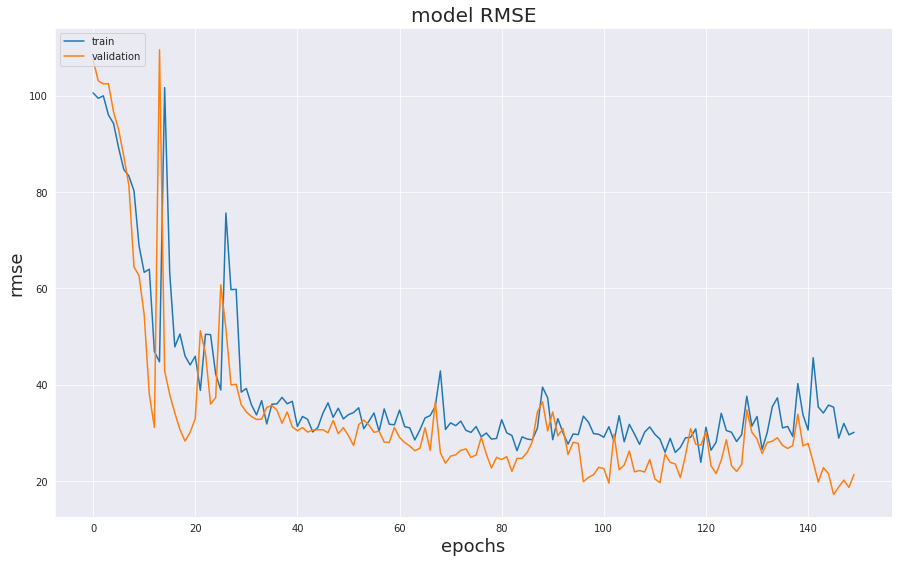

In [56]:
# Define the LSTM model
steps = 10
features = 2

model = Sequential()
model.add(Bidirectional(LSTM(units=30, activation='relu', input_shape=(steps, features))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='Adadelta', loss='mse')
history = model.fit(X_train, y_train, epochs=150, verbose=0, batch_size=170,  validation_split=0.1)
plot_lstm(history, 'multi_train')

In [57]:
train, val = time_series_split(multi_var_train, split=0.9)

train_sd = train['sd'].tolist()
# train_obs = train['observations'].tolist()
train_sunspots = train['sunspots'].tolist()

# Combine last 10 observations of train to validation
val_sd = train_sd[-10:] + val['sd'].tolist()
# val_obs = train_obs[-10:] + val['observations'].tolist()
val_sunspots = train_sunspots[-10:] + val['sunspots'].tolist()

feature1 = np.array(val_sd)
# feature2 = np.array(val_obs)
feature3 = np.array(val_sunspots)

feature1 = feature1.reshape((len(feature1), 1))
# feature2 = feature2.reshape((len(feature2), 1))
feature3 = feature3.reshape((len(feature3), 1))

# horizontally stack columns
valset = np.hstack((feature1, feature3, feature3))

Size of original data: 180
Size of training data: 162
Size of test data: 18


In [58]:
X_val, y_val = multivar_split_sequence(valset, 10)
print(X_val.shape)

(18, 10, 2)


In [59]:
predictions = model.predict(X_val)

MSE: 495.2435
RMSE: 22.2541


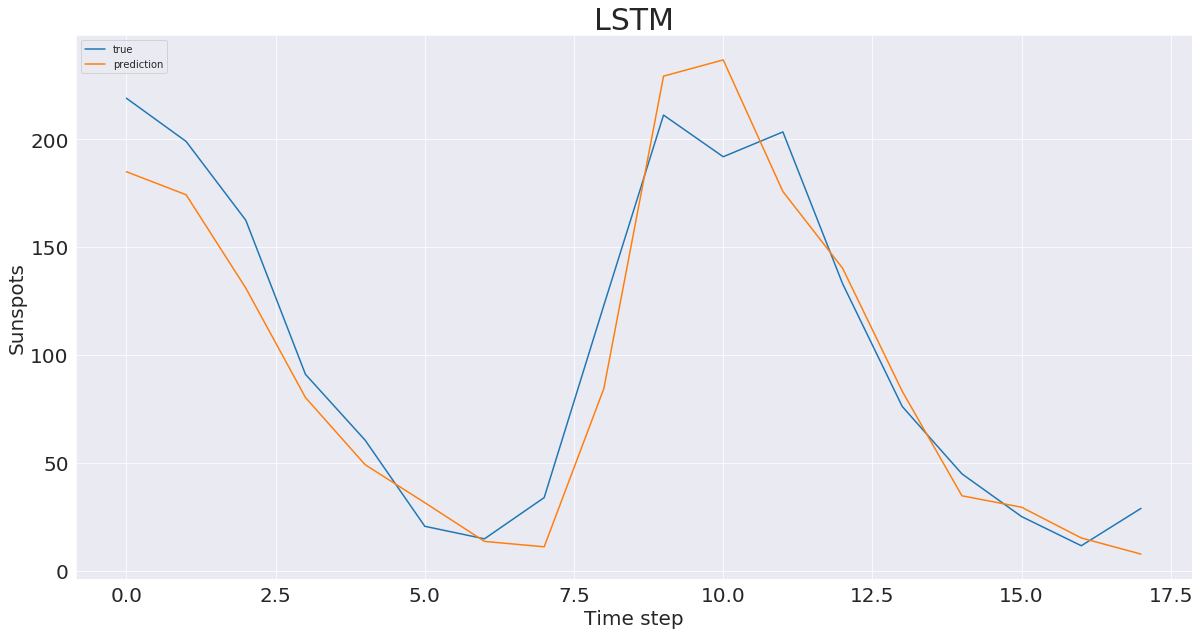

In [60]:
evaluation(y_val, predictions)

## Final multivariate LSTM predictions

In [61]:
# load data
multi_var_test = pd.read_csv(raw_data + 'sunspots_yearly_multivariate-test.csv')
print("Dimensions: {}".format(multi_var_test.shape))
multi_var_test.head()

Dimensions: (21, 4)


,year,sd,observations,sunspots
0,1998,6.6,6353,NaN
1,1999,9.3,6413,NaN
2,2000,10.1,5953,NaN
3,2001,10.5,6558,NaN
4,2002,9.8,6588,NaN


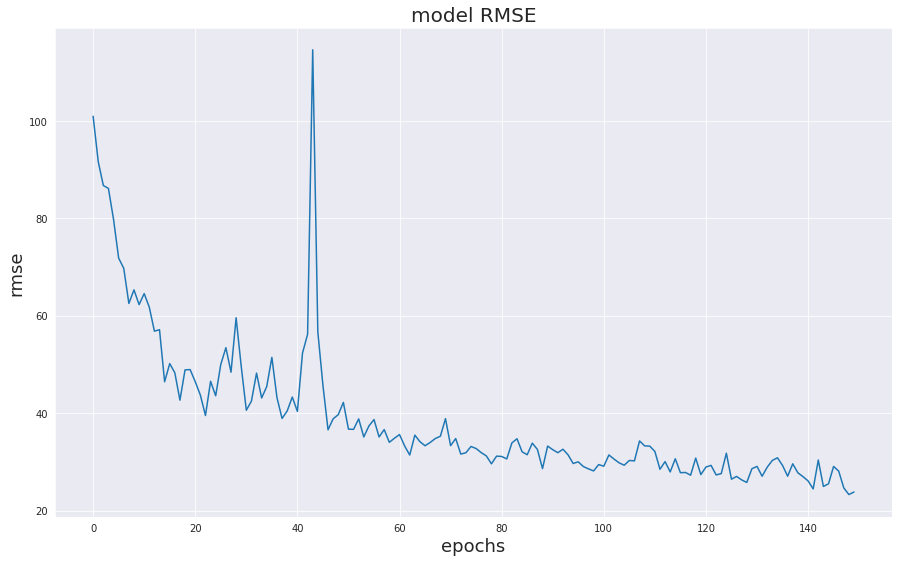

In [109]:
# # Fully trained model
steps = 10
features = 2

model = Sequential()
model.add(Bidirectional(LSTM(units=30, activation='relu', input_shape=(steps, features))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='Adadelta', loss='mse')
history = model.fit(X_train, y_train, epochs=150, verbose=0, batch_size=170)
plot_lstm(history, 'multi_final_train_1', val=False)

In [110]:
train_sd = val['sd'].tolist()
train_sunspot = val['sunspots'].tolist()

prediction = []

for i in range(len(multi_var_test)):
        # Prepare data for prediction input
        feature1 = np.array(train_sd[-10:])
        feature2 = np.array(train_sunspot[-10:])
        feature1 = feature1.reshape((len(feature1), 1))
        feature2 = feature2.reshape((len(feature2), 1))
        test_set = np.hstack((feature1, feature2))
        test_set = np.expand_dims(test_set, axis=0)
        
        # Make prediction
        predict = model.predict(test_set)
        prediction.append(predict[0][0])
        # print(test_set.shape)
        # print(test_set)
        train_sd.append(multi_var_test.iloc[i,1])
        train_sunspot.append(predict[0][0])

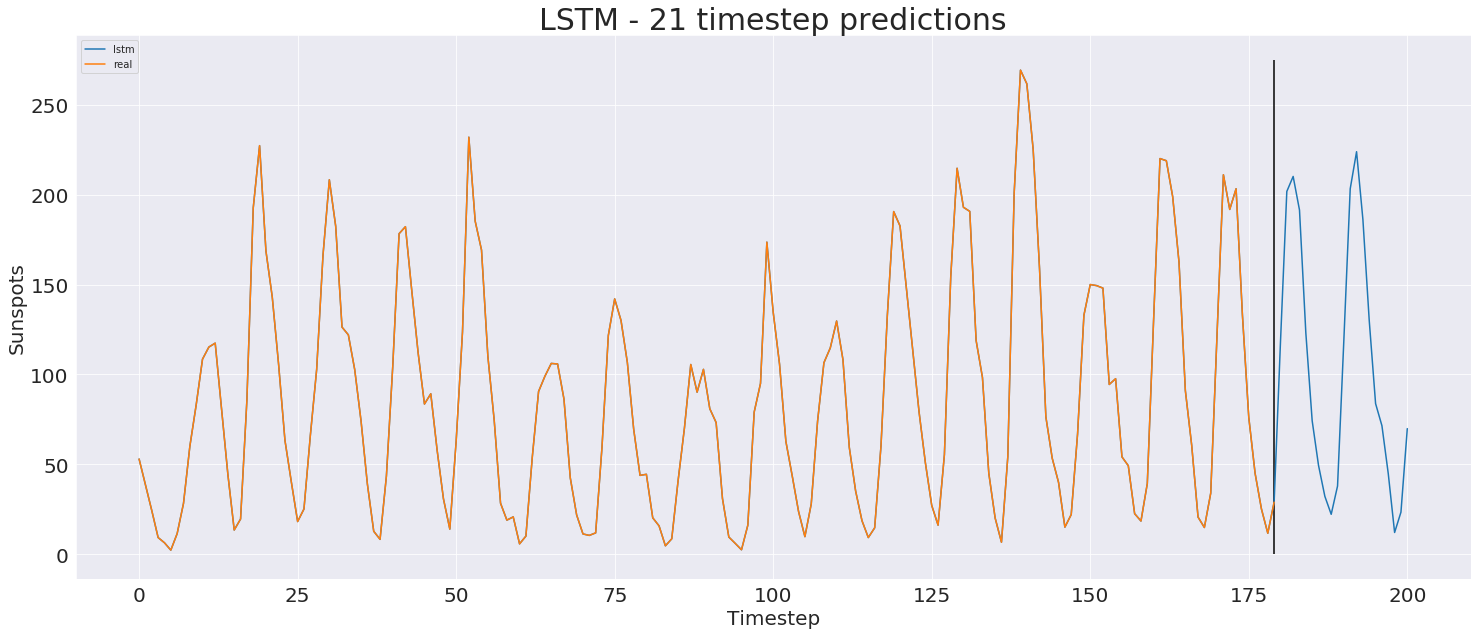

In [112]:
plt.figure(figsize=(25, 10))
plt.plot(multi_var_train['sunspots'].tolist() + prediction)
plt.plot(multi_var_train['sunspots'].tolist())
plt.legend(['lstm', 'real'], loc='upper left')
plt.title("LSTM - 21 timestep predictions", fontdict={'fontsize': 30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Timestep', fontsize=20)
plt.ylabel('Sunspots', fontsize=20)
plt.vlines(179, ymin=0, ymax=275)
plt.show()

In [113]:
multi_var_test['sunspots'] = list(prediction)
multi_var_test.head()

,year,sd,observations,sunspots
0,1998,6.6,6353,117.914825
1,1999,9.3,6413,201.799454
2,2000,10.1,5953,210.154205
3,2001,10.5,6558,191.448593
4,2002,9.8,6588,123.064812


In [114]:
# multi_var_test.to_csv('./multi_lstm_predictions3.csv', index=False)